# Weighted Matrix Factorization for Recommender Systems

In this notebook, after looking at the datasets, we build the feedback matrix and finally train the Weighted Matrix Factorization Model (that is implemented in the *src/wmfact.py* class).

We use the two different strategies to minimise the loss function, WALS and SGD.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.wmfact import WeightedMatrixFactorization

## Data loading and preprocessing
In this section, we load the rating and movie data from CSV files and preprocess it to create the feedback matrix.

The ratings dataset includes three columns (user_id, movie_id, rating). Each row represents a single rating given by a user to a particular movie.
The movies dataset, instead, contains information about the movies themselves (movie_id, title). Each row represents a single movie in the dataset.

In [17]:
# Read data
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

n_ratings = ratings.shape[0]
n_movies = movies.shape[0]
n_users = ratings.user_id.nunique()

print(f'Ratings: {n_ratings}')
print(f'Movies: {n_movies}')
print(f'Users: {n_users}')

Ratings: 100000
Movies: 1682
Users: 943


There are 100000 ratings for 1682 movies and 943 users. The feedback matrix will have $(943\times1682)$ shape.

In [18]:
# compute the sparsity of the data matrix:
sparsity = n_ratings / (n_movies * n_users)
print(f"Sparsity: {sparsity:.2%}")

Sparsity: 6.30%


It is a **sparse matrix**: only $6.30\%$ of the user-item ratings have a value.

### Create Feedback Matrix
In this section, we create a feedback matrix from the ratings data. The feedback matrix represents the ratings given by users for different movies (the missing ratings are encoded with *nan*).

In [19]:
feedbacks = ratings.pivot_table(values='rating', index=['user_id'], columns=['movie_id']).values
display(feedbacks)
print("feedbacks matrix shape: ", feedbacks.shape)

# save the feedbacks matrix
np.save('data/feedbacks.npy', feedbacks)

array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

feedbacks matrix shape:  (943, 1682)


## Weighted Matrix Factorization model

The Weighted Matrix Factorization model aims to factorize the sparse feedback matrix into low-rank user and item matrices, capturing underlying patterns in the data to predict missing ratings. In this implementation, we utilize the Weighted Alternating Least Squares (WALS) algorithm, which iteratively updates user and item embeddings to minimize the reconstruction error of observed ratings, while applying regularization to prevent overfitting.

- **n_iter**: The number of iterations for model fitting. Higher values may lead to better convergence but also increase computational cost.
- **n_latents**: The number of latent factors. A higher number allows the model to capture more complex patterns but may also increase the risk of overfitting.
- **lambda_reg**: The regularization parameter λ. It controls the extent of regularization applied to the model. Higher values of λ lead to stronger regularization.


### Solving the optimisation using WALS method

In [26]:
# hyperparameters:
params = { 'n_latents': 270, 'n_iter': 16, 'lambda_reg': 0.02 }

# fit the model using WALS:
model = WeightedMatrixFactorization(feedbacks, **params)
history_wals = model.fit(method='wals', seed=42, dump=True)

# 'history_wals' will contain the model's loss history at each iteration.

* Fitting the model with wals method: n_iter = 16, n_latents = 270, lambda_reg = 0.02 *


100%|██████████| 16/16 [59:25<00:00, 222.87s/it, loss=3018.48]  


-> Model fitting completed in 3565.96 seconds

-> Model saved to models/wmf_wals_nlat270_niter16_lambdareg0.02.pkl
-> History saved to models/wmf_wals_nlat270_niter16_lambdareg0.02.csv



### Solving the optimisation using SGD method (same hyperparams)
In the context of matrix factorization, SGD aims to minimize the difference between the observed ratings and the predicted ratings by iteratively updating the user and item matrices.

- For each observed user-item pair:
    - Compute the predicted rating using the dot product of the corresponding user and item vectors.
    - Compute the error between the observed rating and the predicted rating.
    - Update the user and item vectors using the gradient of the error with respect to the parameters (user and item vectors).
    - Repeat the process for a fixed number of iterations or until convergence criteria are met.

In [27]:
# fit the model using SGD:
history_sgd = model.fit(method='sgd', seed=42, dump=False)

* Fitting the model with sgd method: n_iter = 16, n_latents = 270, lambda_reg = 0.02 *
Epoch 16/16, User 943/943, Item 1330/1682, Loss: 4852.4475
-> Model fitting completed in 120.34 seconds


### Model evaluation

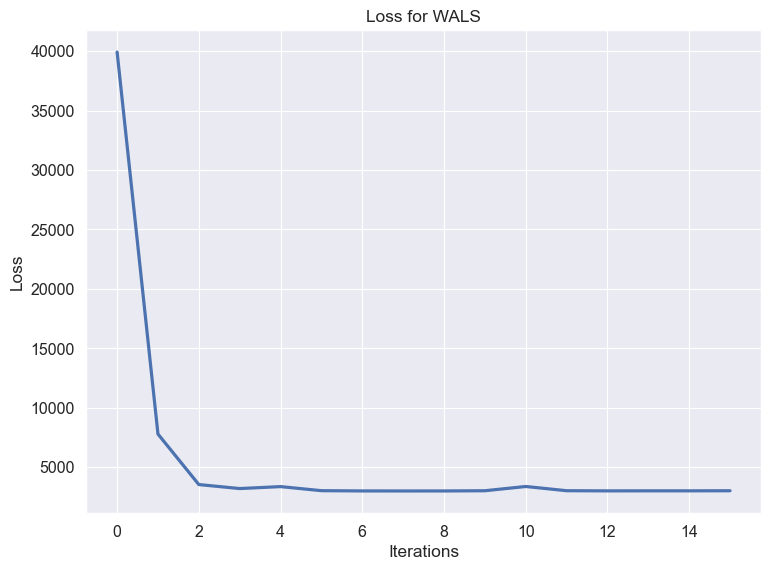

In [28]:
# plot loss from history:
sns.set(rc={'figure.figsize':(8.7,6.27)})
sns.set_context('paper', font_scale=1.3, rc={"lines.linewidth": 2.3})
lists = sorted(history_wals.items())
x, y = zip(*lists)
sns.lineplot(
  x=list(history_wals.keys()), 
  y=list(history_wals.values())
)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss for WALS")
plt.show()

### Let's take an example:

In [30]:
preds = model.predict_all()

user_id = 14
movie_id = 17

print("Real rating: ", feedbacks[user_id, movie_id])
print("Predicted rating: ", preds[user_id, movie_id])

Real rating:  1.0
Predicted rating:  1.028594179715258
